# Volatility-Managed Momentum Strategy

## Intuition Behind Inverse Volatility Scaling

The core idea behind volatility-managed momentum is to **scale down positions when volatility is high** and **scale up positions when volatility is low**. This is based on the empirical observation that momentum strategies tend to perform better during low-volatility periods and worse during high-volatility periods.

### Two Approaches to Volatility Management:

#### 1. **Portfolio-Level Scaling (VM Portfolio)**
- Calculate the momentum spread (top quintile - bottom quintile)
- Scale the entire spread by its inverse conditional volatility: `spread / σ_t`
- **Intuition**: When the momentum spread is volatile, reduce the position size
- **Benefit**: Maintains the relative relationship between winners and losers

#### 2. **Leg-Level Scaling (VM Leg)**
- Scale each leg (winners and losers) separately by their own conditional volatility
- Winners: `winners / σ_winners`
- Losers: `losers / σ_losers`
- Then take the difference: `scaled_winners - scaled_losers`
- **Intuition**: When winners are volatile, reduce winner exposure; when losers are volatile, reduce loser exposure
- **Benefit**: More granular control over each leg's volatility

### Why This Works:
1. **Volatility Clustering**: High volatility periods tend to be followed by high volatility
2. **Momentum Decay**: Momentum signals are less reliable during high volatility
3. **Risk Management**: Reduces exposure during uncertain periods
4. **Performance Enhancement**: Better risk-adjusted returns through dynamic position sizing

The scaling factor `1/σ_t` ensures that:
- When volatility is high (σ_t large) → position size is small
- When volatility is low (σ_t small) → position size is large


In [180]:
import pandas as pd
import numpy as np
from finance_byu.summarize import summary
import matplotlib.pyplot as plt
import seaborn as sns

In [181]:
def load_and_clean_data() -> pd.DataFrame:
    """
    Loads, cleans, and prepares the merged financial dataset for analysis.

    Returns:
        pd.DataFrame: Cleaned DataFrame with relevant columns and calculated features.
    """
    # Load merged data from feather file
    df: pd.DataFrame = pd.read_feather("data/data_botq_2025.ftr")
    
    # Rename columns for consistency and clarity
    df.rename(
        columns={
            "PERMNO": "permno",
            "MthCalDt": "date",
            "MthPrc": "prc",
            "MthRetx": "ret",
            "MthVol": "volume",
            "ShrOut": "shr",
            "CUSIP": "cusip",
            "Ticker": "ticker",
            "act": "current",
            "at": "assets",
            "ch": "cash"
        },
        inplace=True
    )
    
    # Filter for primary exchanges: NASDAQ (Q), NYSE (N), AMEX (A)
    df = df.loc[df.PrimaryExch.isin(["Q", "A", "N"])]
    
    # Remove duplicate rows based on permno and date
    df = df.drop_duplicates(["permno", "date"], keep="first")
    
    # Reset index after dropping duplicates
    df.reset_index(drop=True, inplace=True)
    
    # Convert date column to datetime
    df["date"] = pd.to_datetime(df["date"])
    
    # Sort by permno and date for time series operations
    df.sort_values(by=["permno", "date"], inplace=True)
    
    # Calculate log returns
    df['logret'] = np.log(1 + df['ret'])
    
    # Calculate 12-month momentum (sum of log returns, skipping most recent month)
    df['mom'] = (
        df.groupby('permno')['logret']
        .apply(lambda x: x.rolling(12, min_periods=12).sum().shift(2))
        .reset_index(level=0, drop=True)
    )
    
    # Calculate market equity (me)
    df['me'] = df['shr'] * df['prc']
    
    # Lagged price and market equity
    df['prclag'] = df.groupby('permno')['prc'].shift()
    df['melag'] = df.groupby('permno')['me'].shift()
    
    # Forward fill balance sheet variables within each permno
    df["assets"] = df.groupby("permno")["assets"].ffill()
    df["current"] = df.groupby("permno")["current"].ffill()
    df["cash"] = df.groupby("permno")["cash"].ffill()
    
    # Lagged current-to-asset ratio
    df['currenttoassetlag'] = (df["current"] / df["assets"]).shift()
    
    # Drop intermediate columns no longer needed
    df.drop(columns=["cash", "current", "assets"], inplace=True)
    
    return df

In [182]:
# Get cleaned df
df = load_and_clean_data()

# Get df's for time periods 1980-2025, 2011-2017, 2018-2025, 2000-2010
df1 = df.loc[(df.date >= pd.to_datetime("1985-01-31")) & (df.date < pd.to_datetime("2025-01-01"))] 
df2 = df.loc[(df.date >= pd.to_datetime("2011-01-31")) & (df.date < pd.to_datetime("2017-01-01"))] 
df3 = df.loc[(df.date >= pd.to_datetime("2018-01-31")) & (df.date < pd.to_datetime("2025-01-01"))] 
df4 = df.loc[(df.date >= pd.to_datetime("2000-01-31")) & (df.date < pd.to_datetime("2010-01-01"))] 

# Query for momentum, price, and market equity
df1 = df1.query("mom == mom and prclag >= 5 and melag >= 100").reset_index(drop=True)
df2 = df2.query("mom == mom and prclag >= 5 and melag >= 100").reset_index(drop=True)
df3 = df3.query("mom == mom and prclag >= 5 and melag >= 100").reset_index(drop=True)

WE ARE ATTEMPTING TO MAKE HSTORY WITH **VOLMOM**

In [183]:
def ewma_var(
    series: pd.Series, 
    lambda_ewma: float = 0.94, 
    span = None, 
    alpha = None
) -> pd.Series:
    """
    Compute the exponentially weighted moving average (EWMA) variance of a returns series.

    Parameters
    ----------
    series : pd.Series
        The input time series of returns.
    lambda_ewma : float, optional
        The decay factor for EWMA. Only used if both `span` and `alpha` are None. Default is 0.94.
    span : int, optional
        The span for the EWMA calculation. If provided, overrides `lambda_ewma` and `alpha`.
    alpha : float, optional
        The smoothing factor for EWMA. If provided, overrides `lambda_ewma`.

    Returns
    -------
    pd.Series
        The EWMA variance series.
    """
    # Use span if provided (pandas will internally convert to alpha)
    if span is not None:
        return series.pow(2).ewm(span=span, adjust=False).mean()
    # Use alpha if provided
    if alpha is not None:
        return series.pow(2).ewm(alpha=alpha, adjust=False).mean()
    # Default: use lambda_ewma to set alpha
    return series.pow(2).ewm(alpha=1 - lambda_ewma, adjust=False).mean()

def sharpe(
    series: pd.Series, 
    months_per_year: int = 12, 
    rf: float = 0.0002, 
    annualize: bool = True
) -> float:
    """
    Compute the Sharpe ratio of a return series.

    Parameters
    ----------
    series : pd.Series
        The input time series of returns.
    months_per_year : int, optional
        Number of periods per year (default is 12 for monthly data).
    rf : float, optional
        The risk-free rate per period (default is 0.0002).
    annualize : bool, optional
        Whether to annualize the Sharpe ratio (default is True).

    Returns
    -------
    float
        The (annualized) Sharpe ratio.
    """
    # Calculate mean excess return divided by standard deviation
    s = (series.mean() - rf) / series.std()
    # Annualize if requested
    if annualize:
        return s * np.sqrt(months_per_year)
    return s

def find_3_portfolios(
    df: pd.DataFrame
):
    """
    Construct regular and volatility-managed momentum portfolios.

    This function sorts stocks into momentum quintiles each period, computes the standard
    momentum spread (top minus bottom quintile), and constructs two volatility-managed
    versions: one by scaling the spread by its own conditional volatility, and one by
    scaling each leg (top and bottom quintile) by its own conditional volatility before
    differencing. All volatility estimates use an EWMA with a 12-month span.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least the columns:
            - 'date': Period identifier (e.g., month)
            - 'mom': Momentum score used for sorting
            - 'ret': Return for each stock

    Returns
    -------
    pd.DataFrame
        DataFrame with the following columns, indexed by date:
            - 'spread': Regular momentum spread (top minus bottom quintile)
            - 'vm_portfolio': Volatility-managed spread (portfolio-level scaling)
            - 'vm_leg': Volatility-managed spread (leg-level scaling)
            - 'scale': Inverse conditional volatility used for portfolio-level scaling
    """
    # Bin stocks into 5 momentum quintiles within each date
    df['bins'] = df.groupby('date')['mom'].transform(
        pd.qcut, 5, labels=[str(k) for k in range(1, 6)]
    )
    # Calculate mean return for each bin (quintile) and date
    port = df.groupby(['date', 'bins'], observed=True)['ret'].mean()
    port = port.unstack(level='bins')

    min_var = 1e-8  # Floor on variance to avoid division by zero or blow-ups

    # Calculate the regular momentum spread: top (5) minus bottom (1) quintile
    spread = port['5'] - port['1']
    spread = spread.sort_index()

    # For volatility estimation, use lagged spread (returns observed up to t-1)
    spread_for_var = spread.shift(1)
    span_months = 12  # 12-month effective memory for EWMA
    # Estimate conditional variance of the spread using EWMA
    sigma2_hat = ewma_var(spread_for_var, span=span_months).clip(lower=min_var)
    sigma_hat = np.sqrt(sigma2_hat)  # Conditional standard deviation

    # Volatility-managed portfolio: scale spread by inverse conditional volatility
    raw_vm = spread / sigma_hat

    # Standardize the volatility-managed series to match the volatility of the original spread
    std_spread = spread.dropna().std()
    std_raw_vm = raw_vm.dropna().std()
    c = std_spread / (std_raw_vm if std_raw_vm > 0 else 1.0)
    vm_portfolio = (c * raw_vm).dropna()

    # Calculate the top and bottom quintile return series
    wins = port['5'].sort_index()
    loss = port['1'].sort_index()

    # Estimate conditional variance for each leg using EWMA on lagged returns
    wins_var_hat = ewma_var(wins.shift(1), span=span_months).clip(lower=min_var)
    loss_var_hat = ewma_var(loss.shift(1), span=span_months).clip(lower=min_var)
    wins_sigma = np.sqrt(wins_var_hat)
    loss_sigma = np.sqrt(loss_var_hat)

    # Volatility-managed legs: scale each leg by its own conditional volatility
    wins_raw = wins / wins_sigma
    loss_raw = loss / loss_sigma

    # Construct the leg-level volatility-managed spread
    leg_raw_spread = (wins_raw - loss_raw).dropna()
    std_leg_raw = leg_raw_spread.std()
    c_leg = std_spread / (std_leg_raw if std_leg_raw > 0 else 1.0)
    vm_leg = (c_leg * leg_raw_spread).dropna()



    data = pd.DataFrame({
    'spread': spread,
    'vm_portfolio': vm_portfolio,
    'vm_leg': vm_leg,
    'scale': (1.0 / sigma_hat).replace([np.inf, -np.inf], np.nan)
    }).dropna(how='all').sort_index()

    # This ensures we don't include the first month in our analysis
    if len(data) > 1:
        data = data.iloc[1:].copy()
    
    return data

In [184]:
# Plotting and summary functions for regular vs volatility-managed momentum

monthly_to_annual = np.sqrt(12)

def ann_mean(sr):
    return sr.mean() * 12

def ann_vol(sr):
    return sr.std() * monthly_to_annual

def rolling_ann_sharpe(sr, window=12, rf=0.0002):
    roll_mean = sr.rolling(window).mean() * 12
    roll_std = sr.rolling(window).std() * monthly_to_annual
    return (roll_mean - rf*12) / roll_std

def drawdown(series):
    cum = (1+series).cumprod()
    peak = cum.cummax()
    dd = (cum / peak) - 1
    # dd /= series.std()
    return dd

def plot_cumulative_returns(data, save_path=None):
    """
    Plot cumulative log-returns for regular, VM portfolio-level, and VM leg-level series.
    """
    cum = (1 + data[['spread','vm_portfolio','vm_leg']]).cumprod() - 1

    # CRITICAL FIX: Ensure all cumulative returns start at 0
    cum = cum - cum.iloc[0]

    plt.figure(figsize=(10,5))
    plt.plot(cum.index, np.log1p(cum['spread']), label='Regular spread', linewidth=1.5)
    plt.plot(cum.index, np.log1p(cum['vm_portfolio']), label='VM portfolio-level', linewidth=1.5)
    plt.plot(cum.index, np.log1p(cum['vm_leg']), label='VM leg-level', linewidth=1.5)
    plt.legend()
    plt.title('Cumulative returns (monthly)')
    plt.ylabel('Cumulative log return')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_rolling_sharpe(data, window=12, rf=0.0002, save_path=None):
    """
    Plot rolling annualized Sharpe ratios for the three series.
    """
    plt.figure(figsize=(10,4))
    rs_sp = rolling_ann_sharpe(data['spread'], window=window, rf=rf)
    rs_vm = rolling_ann_sharpe(data['vm_portfolio'], window=window, rf=rf)
    rs_leg = rolling_ann_sharpe(data['vm_leg'], window=window, rf=rf)
    plt.plot(rs_sp.index[2:], rs_sp[2:], label='Regular spread', alpha=0.9)
    plt.plot(rs_vm.index[2:], rs_vm[2:], label='VM portfolio-level', alpha=0.9)
    plt.plot(rs_leg.index[2:], rs_leg[2:], label='VM leg-level', alpha=0.9)
    plt.axhline(0, color='k', linewidth=0.5)
    plt.legend()
    plt.title(f'Rolling {window}-month annualized Sharpe')
    plt.ylabel('Sharpe')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_rolling_volatility(data, window=12, save_path=None):
    """
    Plot rolling annualized volatility for the three series.
    """
    plt.figure(figsize=(10,4))
    rv_sp = data['spread'].rolling(window).std() * monthly_to_annual
    rv_vm = data['vm_portfolio'].rolling(window).std() * monthly_to_annual
    rv_leg = data['vm_leg'].rolling(window).std() * monthly_to_annual
    plt.plot(rv_sp.index[2:], rv_sp[2:], label='Regular spread', alpha=0.9)
    plt.plot(rv_vm.index[2:], rv_vm[2:], label='VM portfolio-level', alpha=0.9)
    plt.plot(rv_leg.index[2:], rv_leg[2:], label='VM leg-level', alpha=0.9)
    plt.legend()
    plt.title(f'Rolling {window}-month annualized volatility')
    plt.ylabel('Annualized volatility')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_drawdowns(data, save_path=None):
    """
    Plot drawdown curves for the three series.
    """
    dd_sp = drawdown(data['spread'])
    dd_vm = drawdown(data['vm_portfolio'])
    dd_leg = drawdown(data['vm_leg'])
    plt.figure(figsize=(10,5))
    plt.plot(dd_sp.index, dd_sp, label='Regular spread')
    plt.plot(dd_vm.index, dd_vm, label='VM portfolio-level')
    plt.plot(dd_leg.index, dd_leg, label='VM leg-level')
    plt.legend()
    plt.title('Drawdowns (from cumulative peaks)')
    plt.ylabel('Drawdown')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_scale_and_histogram(scale_series, save_path=None):
    """
    Plot the scale (1/sigma_hat) time series and its histogram.
    """
    fig, axs = plt.subplots(1,2,figsize=(12,4))
    axs[0].plot(scale_series.index[1:], scale_series[1:], color='tab:purple')
    axs[0].set_title(r'Scale $(1 / \hat{\sigma})$ over time')
    axs[0].set_ylabel('Scale')
    axs[0].grid(alpha=0.2)
    sns.histplot(scale_series.dropna()[1:], bins=40, ax=axs[1], color='tab:purple')
    axs[1].set_title(r'Distribution of scale $(1 / \hat{\sigma})$')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_returns_vs_scale(data, save_path=None):
    """
    Scatter plots: monthly returns vs scale for regular and VM portfolio-level.
    """
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.scatter(data['scale'], data['spread'], alpha=0.5, s=20)
    plt.xlabel('Scale (1/sigma_hat)')
    plt.ylabel('Regular spread monthly return')
    plt.title('Regular return vs scale')
    plt.grid(alpha=0.2)

    plt.subplot(1,2,2)
    plt.scatter(data['scale'], data['vm_portfolio'], alpha=0.5, s=20, color='tab:orange')
    plt.xlabel('Scale (1/sigma_hat)')
    plt.ylabel('VM portfolio monthly return')
    plt.title('VM return vs scale')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_monthly_heatmap(series, title, save_path=None, vmin=-0.2, vmax=0.2):
    """
    Plot a monthly heatmap of returns (years on y, months on x).
    """
    s = series.dropna().copy()
    s = s.to_frame('r')
    s['year'] = s.index.year
    s['month'] = s.index.month
    pivot = s.pivot_table(index='year', columns='month', values='r', aggfunc='mean')
    plt.figure(figsize=(12,8))
    sns.heatmap(pivot, cmap='RdYlGn', center=0, vmin=vmin, vmax=vmax, cbar_kws={'label':'monthly return'})
    plt.title(title)
    plt.ylabel('Year')
    plt.xlabel('Month')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def print_summary_table(data):
    """
    Print a summary table: annualized mean, vol, Sharpe, max drawdown for each series.
    """
    dd_sp = drawdown(data['spread'])
    dd_vm = drawdown(data['vm_portfolio'])
    dd_leg = drawdown(data['vm_leg'])
    summary = pd.DataFrame(index=['regular','vm_portfolio','vm_leg'])
    summary['ann_mean'] = [ann_mean(data['spread'].dropna()), ann_mean(data['vm_portfolio'].dropna()), ann_mean(data['vm_leg'].dropna())]
    summary['ann_vol'] = [ann_vol(data['spread'].dropna()), ann_vol(data['vm_portfolio'].dropna()), ann_vol(data['vm_leg'].dropna())]
    summary['ann_sharpe'] = summary['ann_mean'] / summary['ann_vol']
    summary['max_drawdown'] = [dd_sp.min(), dd_vm.min(), dd_leg.min()]
    print(summary.round(4))


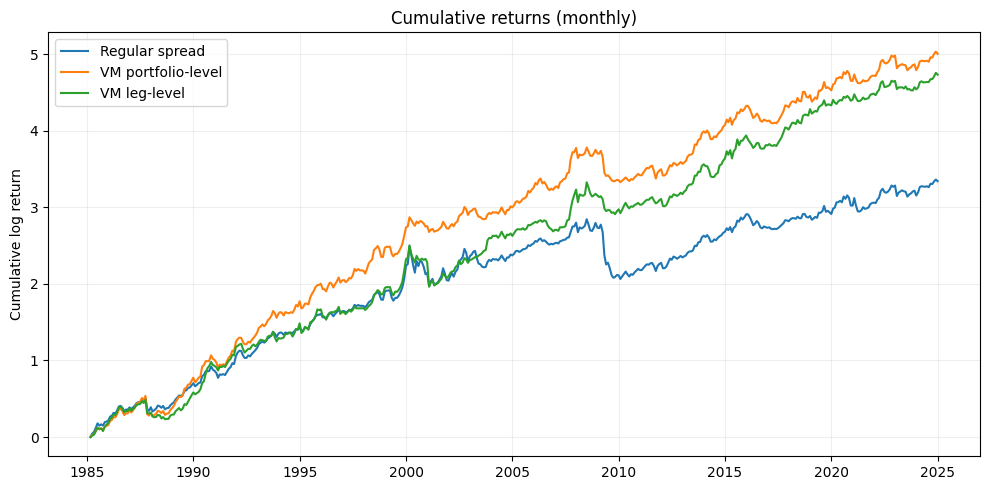

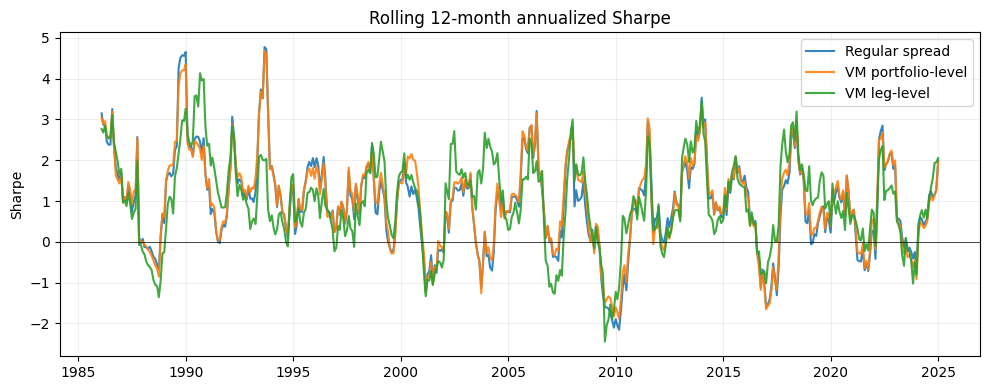

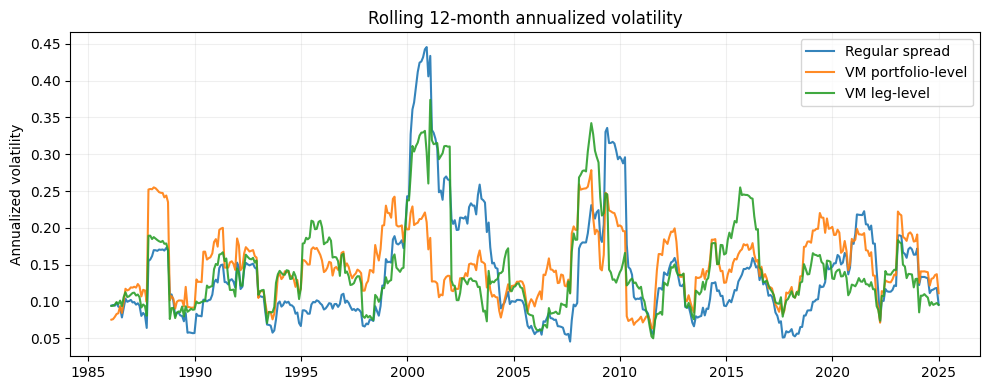

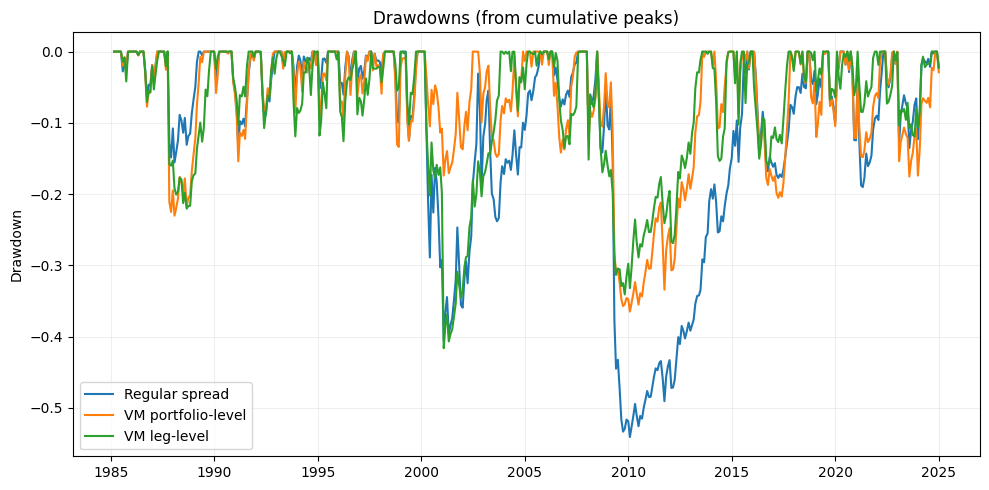

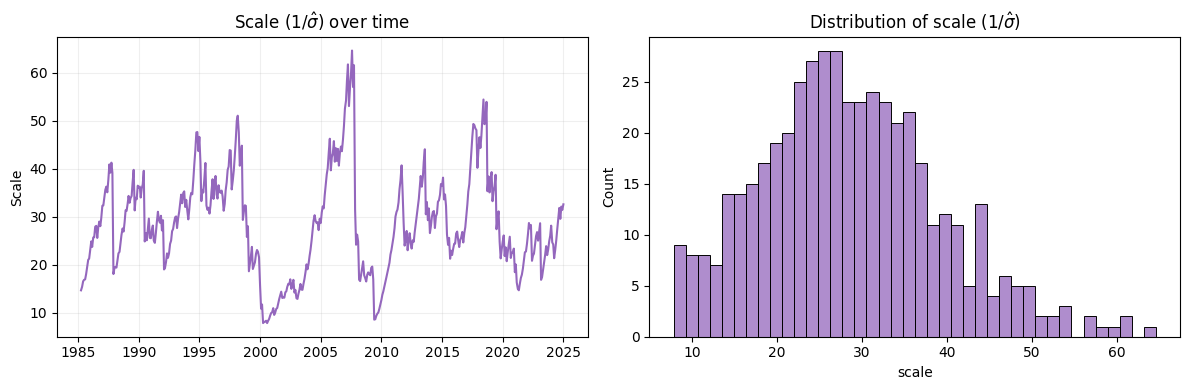

              ann_mean  ann_vol  ann_sharpe  max_drawdown
regular         0.0962   0.1549      0.6211       -0.5408
vm_portfolio    0.1382   0.1553      0.8901       -0.3648
vm_leg          0.1314   0.1553      0.8462       -0.4161


In [185]:
data1 = find_3_portfolios(df1)

# Call plotting functions with save_path argument
plot_cumulative_returns(data1, save_path="new_figures/1980_2025_cumulative_returns.png")
plot_rolling_sharpe(data1, save_path="new_figures/1980_2025_rolling_sharpe.png")
plot_rolling_volatility(data1, save_path="new_figures/1980_2025_rolling_volatility.png")
plot_drawdowns(data1, save_path="new_figures/1980_2025_drawdowns.png")
plot_scale_and_histogram(data1['scale'], save_path="new_figures/1980_2025_scale_histogram.png")

# Print summary table
print_summary_table(data1)

# Volatility Management Intuition

## Understanding Inverse Volatility Scaling

The core idea behind volatility-managed momentum is to **scale down positions when volatility is high** and **scale up positions when volatility is low**. This is based on the empirical observation that momentum strategies tend to perform better during low-volatility periods and worse during high-volatility periods.

### Two Approaches to Volatility Management:

#### 1. **Portfolio-Level Scaling (VM Portfolio)**
- Calculate the momentum spread (top quintile - bottom quintile)
- Scale the entire spread by its inverse conditional volatility: `spread / σ_t`
- **Intuition**: When the momentum spread is volatile, reduce the position size
- **Benefit**: Maintains the relative relationship between winners and losers

#### 2. **Leg-Level Scaling (VM Leg)**
- Scale each leg (winners and losers) separately by their own conditional volatility
- Winners: `winners / σ_winners`
- Losers: `losers / σ_losers`
- Then take the difference: `scaled_winners - scaled_losers`
- **Intuition**: When winners are volatile, reduce winner exposure; when losers are volatile, reduce loser exposure
- **Benefit**: More granular control over each leg's volatility

### Why This Works:
1. **Volatility Clustering**: High volatility periods tend to be followed by high volatility
2. **Momentum Decay**: Momentum signals are less reliable during high volatility
3. **Risk Management**: Reduces exposure during uncertain periods
4. **Performance Enhancement**: Better risk-adjusted returns through dynamic position sizing

The scaling factor `1/σ_t` ensures that:
- When volatility is high (σ_t large) → position size is small
- When volatility is low (σ_t small) → position size is large


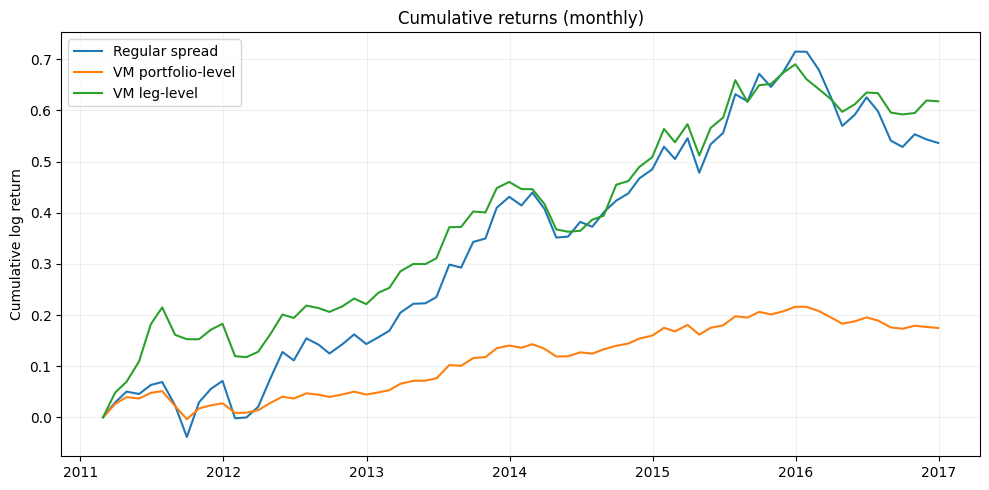

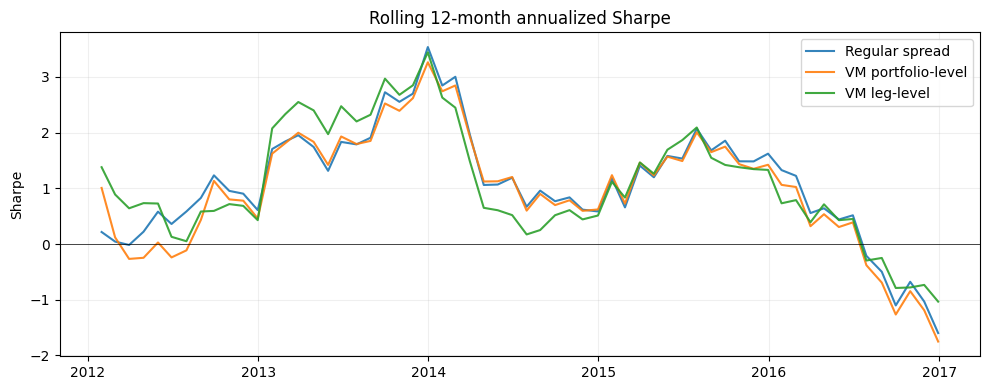

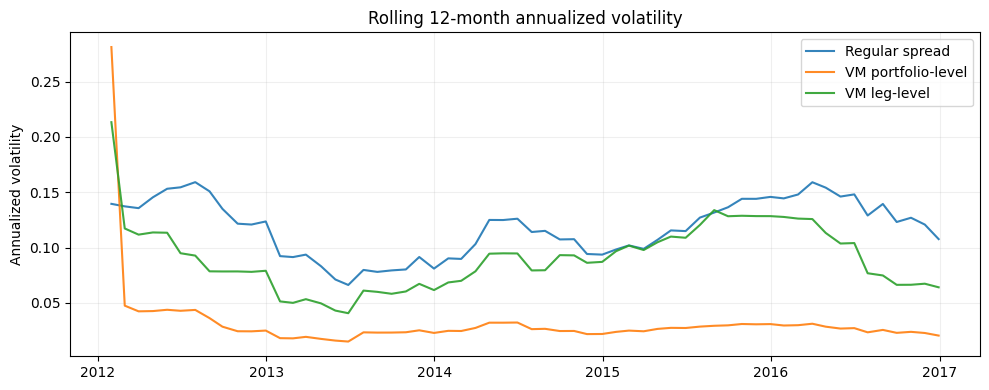

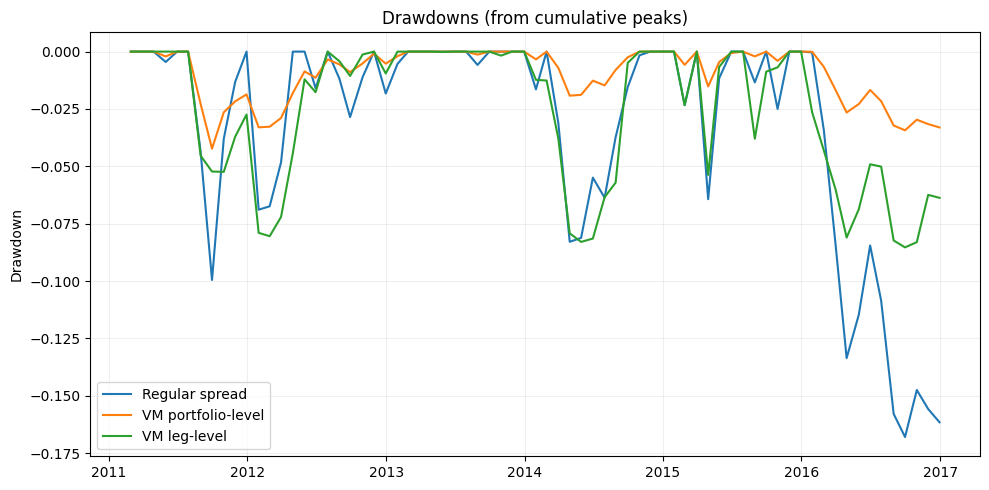

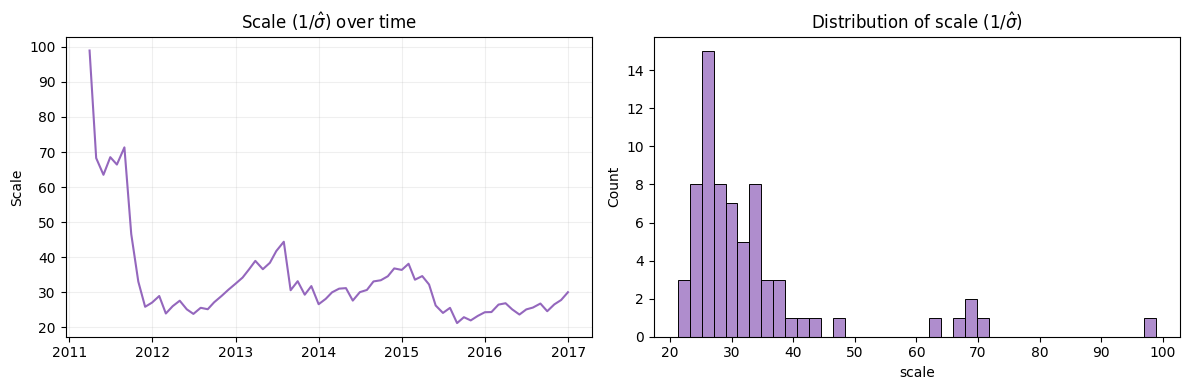

              ann_mean  ann_vol  ann_sharpe  max_drawdown
regular         0.1004   0.1180      0.8513       -0.1679
vm_portfolio    0.0710   0.1172      0.6055       -0.0423
vm_leg          0.1279   0.1172      1.0911       -0.0853


In [186]:
data2 = find_3_portfolios(df2)

# Call plotting functions 
plot_cumulative_returns(data2, save_path="new_figures/2011_2017_cumulative_returns.png")
plot_rolling_sharpe(data2, save_path="new_figures/2011_2017_rolling_sharpe.png")
plot_rolling_volatility(data2, save_path="new_figures/2011_2017_rolling_volatility.png")
plot_drawdowns(data2, save_path="new_figures/2011_2017_drawdowns.png")
plot_scale_and_histogram(data2['scale'], save_path="new_figures/2011_2017_scale_histogram.png")

# Print summary table
print_summary_table(data2)

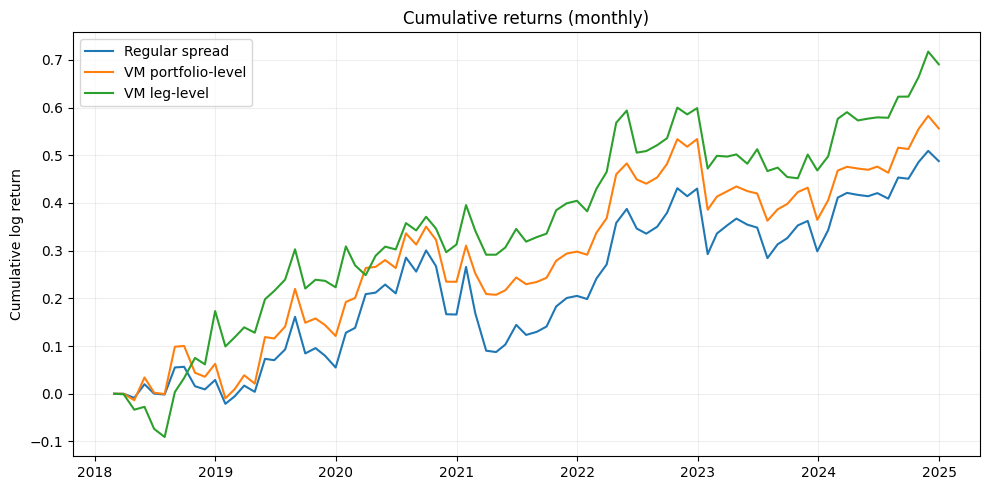

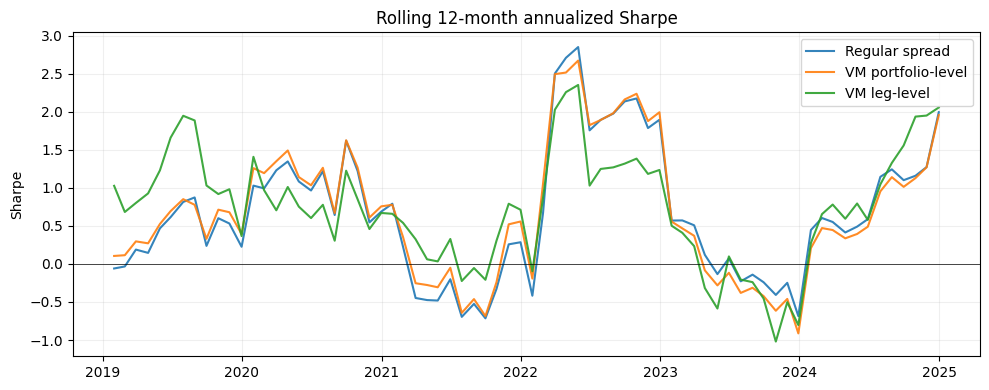

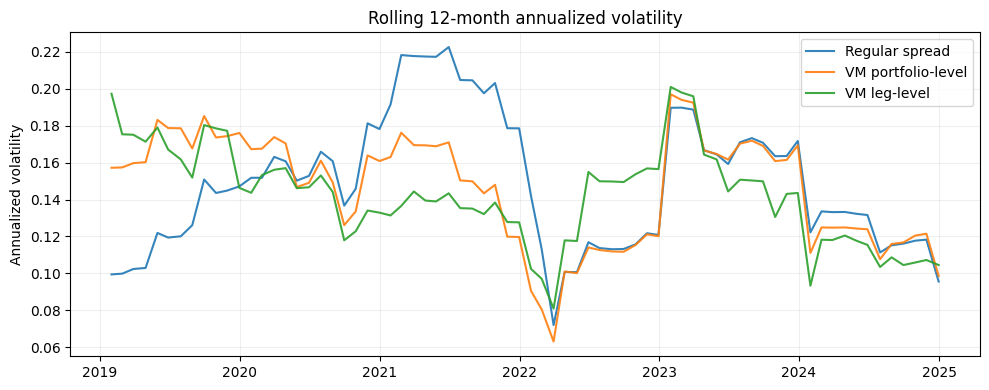

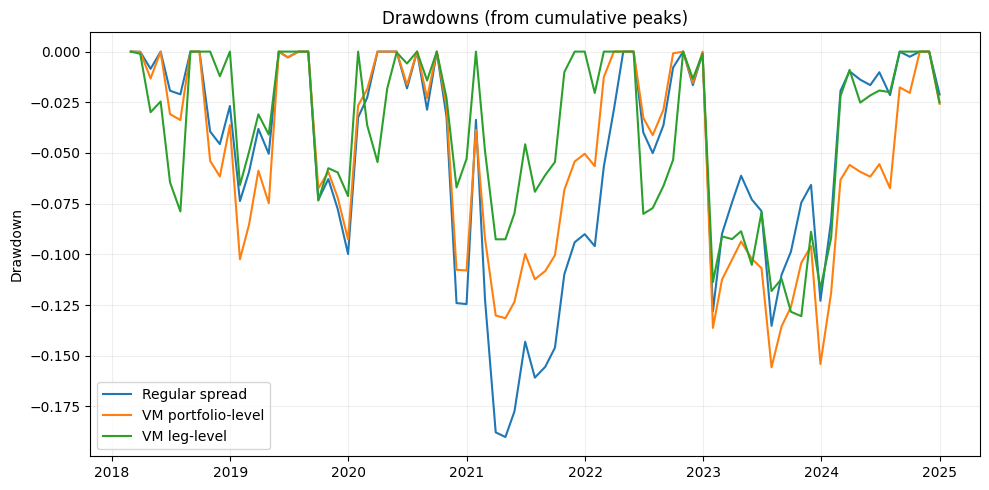

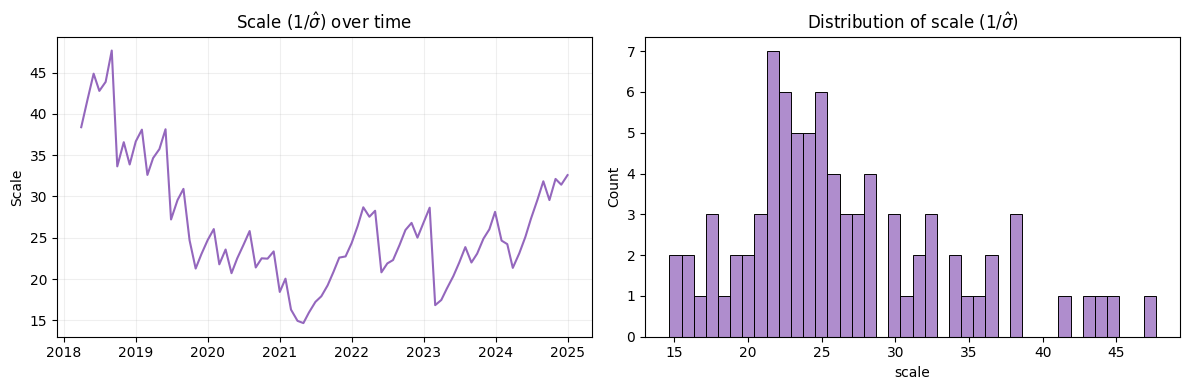

              ann_mean  ann_vol  ann_sharpe  max_drawdown
regular         0.1004   0.1180      0.8513       -0.1679
vm_portfolio    0.0710   0.1172      0.6055       -0.0423
vm_leg          0.1279   0.1172      1.0911       -0.0853


In [187]:
data3 = find_3_portfolios(df3)

# Call plotting functions (without save_path argument)
plot_cumulative_returns(data3, save_path="new_figures/2018_2025_cumulative_returns.png")
plot_rolling_sharpe(data3, save_path="new_figures/2018_2025_rolling_sharpe.png")
plot_rolling_volatility(data3, save_path="new_figures/2018_2025_rolling_volatility.png")
plot_drawdowns(data3, save_path="new_figures/2018_2025_drawdowns.png")
plot_scale_and_histogram(data3['scale'], save_path="new_figures/2018_2025_scale_histogram.png")

# Print summary table
print_summary_table(data2)

/tmp/ipykernel_7266/3392469069.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = df.groupby('date')['mom'].transform(


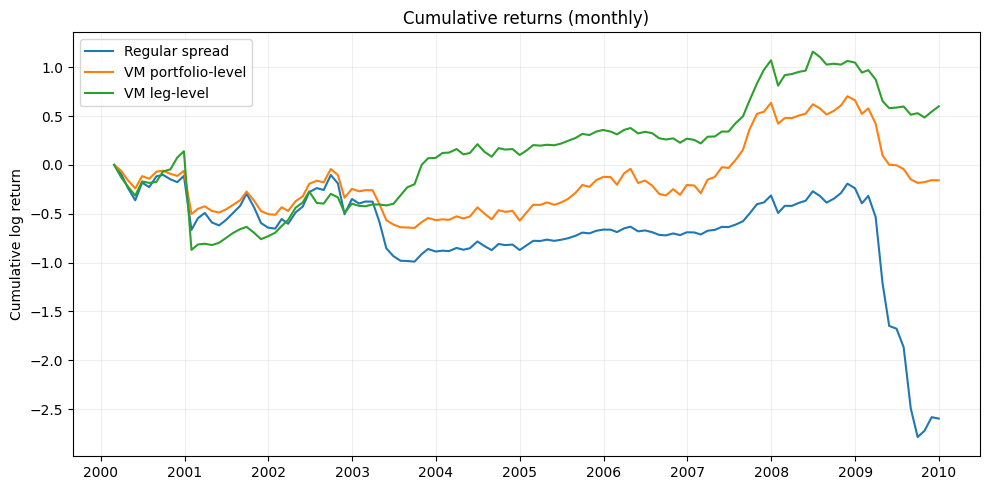

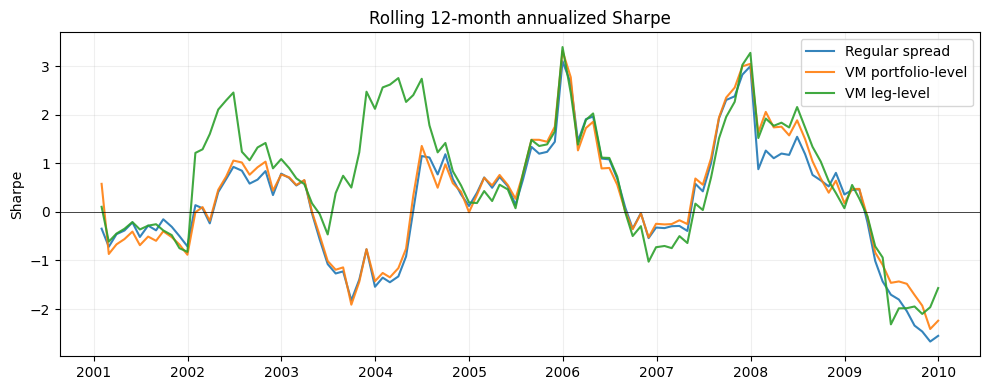

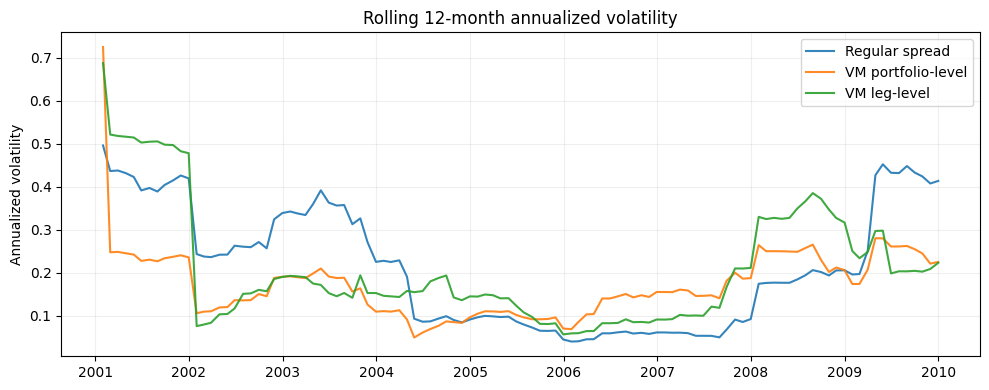

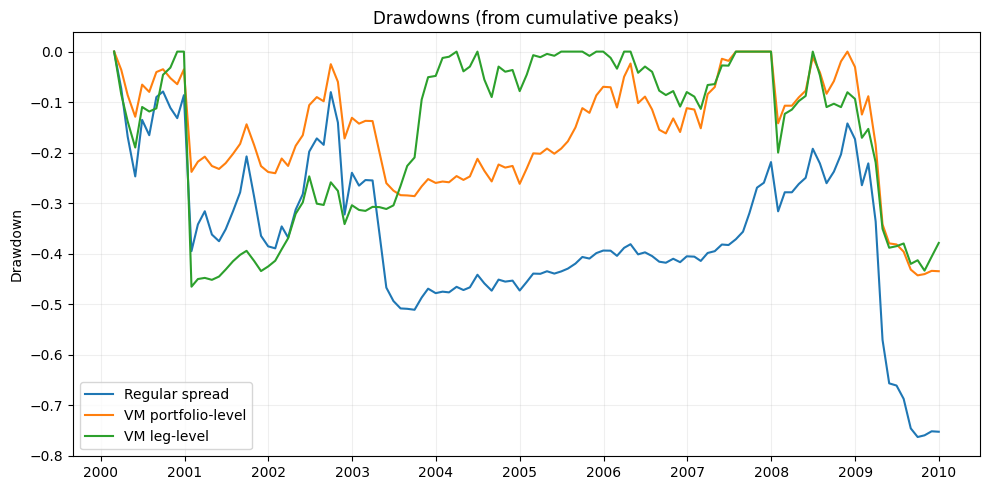

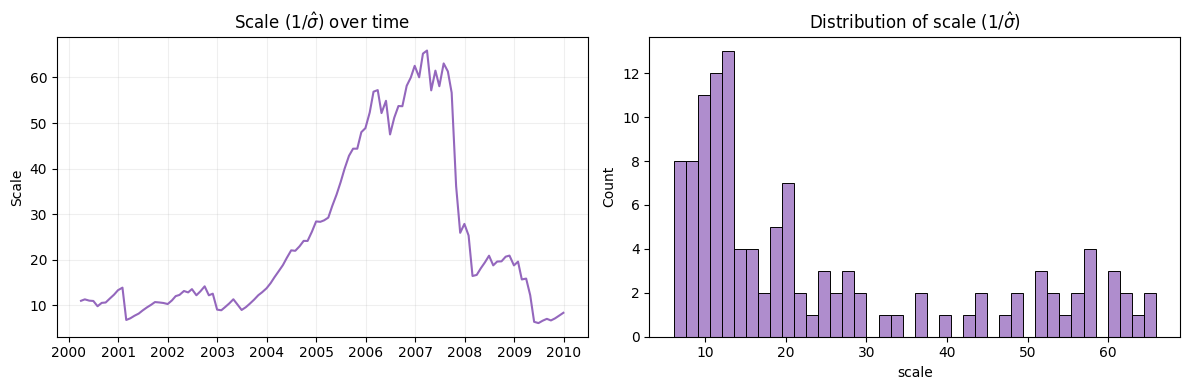

              ann_mean  ann_vol  ann_sharpe  max_drawdown
regular        -0.0766   0.2786     -0.2749       -0.7630
vm_portfolio    0.0744   0.2774      0.2682       -0.4430
vm_leg          0.1235   0.2774      0.4452       -0.4654


In [188]:
data4 = find_3_portfolios(df4)

# Call plotting functions (without save_path argument)
plot_cumulative_returns(data4, save_path="new_figures/2000_2010_cumulative_returns.png")
plot_rolling_sharpe(data4, save_path="new_figures/2000_2010_rolling_sharpe.png")
plot_rolling_volatility(data4, save_path="new_figures/2000_2010_rolling_volatility.png")
plot_drawdowns(data4, save_path="new_figures/2000_2010_drawdowns.png")
plot_scale_and_histogram(data4['scale'], save_path="new_figures/2000_2010_scale_histogram.png")

# Print summary table
print_summary_table(data4)

In [189]:
# Enhanced Statistics Table with T-tests and Significance Testing
import scipy.stats as stats

def print_enhanced_summary_table(data, period_name=""):
    """
    Print a comprehensive summary table with statistics and t-tests for any time period.
    """
    # Calculate drawdowns
    dd_sp = drawdown(data['spread'])
    dd_vm = drawdown(data['vm_portfolio'])
    dd_leg = drawdown(data['vm_leg'])
    
    # Get clean data
    spread_clean = data['spread'].dropna()
    vm_port_clean = data['vm_portfolio'].dropna()
    vm_leg_clean = data['vm_leg'].dropna()
    
    # Calculate statistics
    summary = pd.DataFrame(index=['Regular Momentum', 'VM Portfolio', 'VM Leg'])
    
    # Annualized statistics
    summary['Ann. Mean (%)'] = [ann_mean(spread_clean) * 100, 
                               ann_mean(vm_port_clean) * 100, 
                               ann_mean(vm_leg_clean) * 100]
    
    summary['Ann. Vol (%)'] = [ann_vol(spread_clean) * 100, 
                              ann_vol(vm_port_clean) * 100, 
                              ann_vol(vm_leg_clean) * 100]
    
    summary['Sharpe Ratio'] = [ann_mean(spread_clean) / ann_vol(spread_clean),
                              ann_mean(vm_port_clean) / ann_vol(vm_port_clean),
                              ann_mean(vm_leg_clean) / ann_vol(vm_leg_clean)]
    
    summary['Max Drawdown (%)'] = [dd_sp.min() * 100, 
                                  dd_vm.min() * 100, 
                                  dd_leg.min() * 100]
    
    # T-statistics for significance testing
    summary['T-Stat'] = [stats.ttest_1samp(spread_clean, 0)[0],
                        stats.ttest_1samp(vm_port_clean, 0)[0],
                        stats.ttest_1samp(vm_leg_clean, 0)[0]]
    
    # P-values
    summary['P-Value'] = [stats.ttest_1samp(spread_clean, 0)[1],
                         stats.ttest_1samp(vm_port_clean, 0)[1],
                         stats.ttest_1samp(vm_leg_clean, 0)[1]]
    
    # Number of observations
    summary['N Obs'] = [len(spread_clean), len(vm_port_clean), len(vm_leg_clean)]
    
    print("=" * 80)
    print(f"COMPREHENSIVE PERFORMANCE SUMMARY - {period_name}")
    print("=" * 80)
    print(summary.round(4))
    print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.1")
    
    # Add significance stars
    significance = summary['P-Value'].apply(lambda x: '***' if x < 0.01 else '**' if x < 0.05 else '*' if x < 0.1 else '')
    print("\nSignificance:")
    for idx, sig in significance.items():
        print(f"{idx}: {sig}")
    
    return summary

# Print enhanced statistics for ALL time periods
print("=" * 100)
print("ENHANCED STATISTICS FOR ALL TIME PERIODS")
print("=" * 100)

print("\n1. FULL PERIOD (1980-2025):")
print_enhanced_summary_table(data1, "1980-2025")

print("\n2. RECENT PERIOD (2011-2017):")
print_enhanced_summary_table(data2, "2011-2017")

print("\n3. LATEST PERIOD (2018-2025):")
print_enhanced_summary_table(data3, "2018-2025")

print("\n4. DOT-COM PERIOD (2000-2010):")
print_enhanced_summary_table(data4, "2000-2010")


ENHANCED STATISTICS FOR ALL TIME PERIODS

1. FULL PERIOD (1980-2025):
COMPREHENSIVE PERFORMANCE SUMMARY - 1980-2025
                  Ann. Mean (%)  Ann. Vol (%)  Sharpe Ratio  Max Drawdown (%)  \
Regular Momentum         9.6207       15.4890        0.6211          -54.0759   
VM Portfolio            13.8191       15.5255        0.8901          -36.4789   
VM Leg                  13.1371       15.5255        0.8462          -41.6145   

                  T-Stat  P-Value  N Obs  
Regular Momentum  3.9243   0.0001    479  
VM Portfolio      5.6236   0.0000    479  
VM Leg            5.3460   0.0000    479  

Significance levels: *** p<0.01, ** p<0.05, * p<0.1

Significance:
Regular Momentum: ***
VM Portfolio: ***
VM Leg: ***

2. RECENT PERIOD (2011-2017):
COMPREHENSIVE PERFORMANCE SUMMARY - 2011-2017
                  Ann. Mean (%)  Ann. Vol (%)  Sharpe Ratio  Max Drawdown (%)  \
Regular Momentum        10.0428       11.7974        0.8513          -16.7940   
VM Portfolio             7.0

,Ann. Mean (%),Ann. Vol (%),Sharpe Ratio,Max Drawdown (%),T-Stat,P-Value,N Obs
Regular Momentum,-7.658503,27.856855,-0.274923,-76.298427,-0.865754,0.388382,119
VM Portfolio,7.440624,27.741100,0.268217,-44.296415,0.844634,0.400024,119
VM Leg,12.349397,27.741100,0.445166,-46.539534,1.401861,0.163582,119


In [190]:
# Export Portfolio Statistics to CSV Files
import os

# Create csv folder if it doesn't exist
os.makedirs('csv', exist_ok=True)

def export_portfolio_stats_to_csv(data, period_name, filename):
    """
    Export portfolio statistics to CSV file for a specific time period.
    """
    # Calculate drawdowns
    dd_sp = drawdown(data['spread'])
    dd_vm = drawdown(data['vm_portfolio'])
    dd_leg = drawdown(data['vm_leg'])
    
    # Get clean data
    spread_clean = data['spread'].dropna()
    vm_port_clean = data['vm_portfolio'].dropna()
    vm_leg_clean = data['vm_leg'].dropna()
    
    # Calculate statistics
    stats_data = {
        'Portfolio': ['Regular Momentum', 'VM Portfolio', 'VM Leg'],
        'Period': [period_name] * 3,
        'Ann_Mean_Pct': [ann_mean(spread_clean) * 100, 
                        ann_mean(vm_port_clean) * 100, 
                        ann_mean(vm_leg_clean) * 100],
        'Ann_Vol_Pct': [ann_vol(spread_clean) * 100, 
                       ann_vol(vm_port_clean) * 100, 
                       ann_vol(vm_leg_clean) * 100],
        'Ann_Sharpe': [ann_mean(spread_clean) / ann_vol(spread_clean),
                      ann_mean(vm_port_clean) / ann_vol(vm_port_clean),
                      ann_mean(vm_leg_clean) / ann_vol(vm_leg_clean)],
        'Max_Drawdown_Pct': [dd_sp.min() * 100, 
                            dd_vm.min() * 100, 
                            dd_leg.min() * 100],
        'T_Stat': [stats.ttest_1samp(spread_clean, 0)[0],
                  stats.ttest_1samp(vm_port_clean, 0)[0],
                  stats.ttest_1samp(vm_leg_clean, 0)[0]],
        'P_Value': [stats.ttest_1samp(spread_clean, 0)[1],
                   stats.ttest_1samp(vm_port_clean, 0)[1],
                   stats.ttest_1samp(vm_leg_clean, 0)[1]],
        'N_Obs': [len(spread_clean), len(vm_port_clean), len(vm_leg_clean)]
    }
    
    # Create DataFrame and save to CSV
    df_stats = pd.DataFrame(stats_data)
    df_stats.to_csv(f'csv/{filename}', index=False)
    print(f"✅ Exported {period_name} statistics to csv/{filename}")
    return df_stats

# Export statistics for all time periods
print("=" * 80)
print("EXPORTING PORTFOLIO STATISTICS TO CSV FILES")
print("=" * 80)

# Export each time period
df1_stats = export_portfolio_stats_to_csv(data1, "1980-2025", "portfolio_stats_1980_2025.csv")
df2_stats = export_portfolio_stats_to_csv(data2, "2011-2017", "portfolio_stats_2011_2017.csv")
df3_stats = export_portfolio_stats_to_csv(data3, "2018-2025", "portfolio_stats_2018_2025.csv")
df4_stats = export_portfolio_stats_to_csv(data4, "2000-2010", "portfolio_stats_2000_2010.csv")

# Create combined summary file
print("\n📊 Creating combined summary file...")
combined_stats = pd.concat([df1_stats, df2_stats, df3_stats, df4_stats], ignore_index=True)
combined_stats.to_csv('csv/portfolio_stats_combined.csv', index=False)
print("✅ Exported combined statistics to csv/portfolio_stats_combined.csv")

# Display summary of what was exported
print("\n" + "=" * 80)
print("CSV FILES CREATED:")
print("=" * 80)
print("📁 csv/portfolio_stats_1980_2025.csv")
print("📁 csv/portfolio_stats_2011_2017.csv") 
print("📁 csv/portfolio_stats_2018_2025.csv")
print("📁 csv/portfolio_stats_2000_2010.csv")
print("📁 csv/portfolio_stats_combined.csv")
print("\nEach CSV contains: Portfolio, Period, Ann_Mean_Pct, Ann_Vol_Pct, Ann_Sharpe, Max_Drawdown_Pct, T_Stat, P_Value, N_Obs")


EXPORTING PORTFOLIO STATISTICS TO CSV FILES
✅ Exported 1980-2025 statistics to csv/portfolio_stats_1980_2025.csv
✅ Exported 2011-2017 statistics to csv/portfolio_stats_2011_2017.csv
✅ Exported 2018-2025 statistics to csv/portfolio_stats_2018_2025.csv
✅ Exported 2000-2010 statistics to csv/portfolio_stats_2000_2010.csv

📊 Creating combined summary file...
✅ Exported combined statistics to csv/portfolio_stats_combined.csv

CSV FILES CREATED:
📁 csv/portfolio_stats_1980_2025.csv
📁 csv/portfolio_stats_2011_2017.csv
📁 csv/portfolio_stats_2018_2025.csv
📁 csv/portfolio_stats_2000_2010.csv
📁 csv/portfolio_stats_combined.csv

Each CSV contains: Portfolio, Period, Ann_Mean_Pct, Ann_Vol_Pct, Ann_Sharpe, Max_Drawdown_Pct, T_Stat, P_Value, N_Obs
